## Import Packages and load Data Frame

In [1]:
# Standard imports
import re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from io import StringIO
import csv
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from sklearn.feature_extraction.text import CountVectorizer



# For NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("NLTK data downloaded successfully")

C:\Users\mala\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NLTK data downloaded successfully


In [2]:
# Download data from https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data
# Load your train data
df = pd.read_csv('train.csv')
df.head(5)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# Change toxic_related column to single column
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df['toxic'] = (df[label_cols].sum(axis=1) > 0).astype(int)


EXPLORATORY DATA ANALYSIS
Label Distribution:
Non-toxic (0): 143,346 (89.8%)
Toxic (1): 16,225 (10.2%)
Average text length: 394 characters
Average word count: 67 words


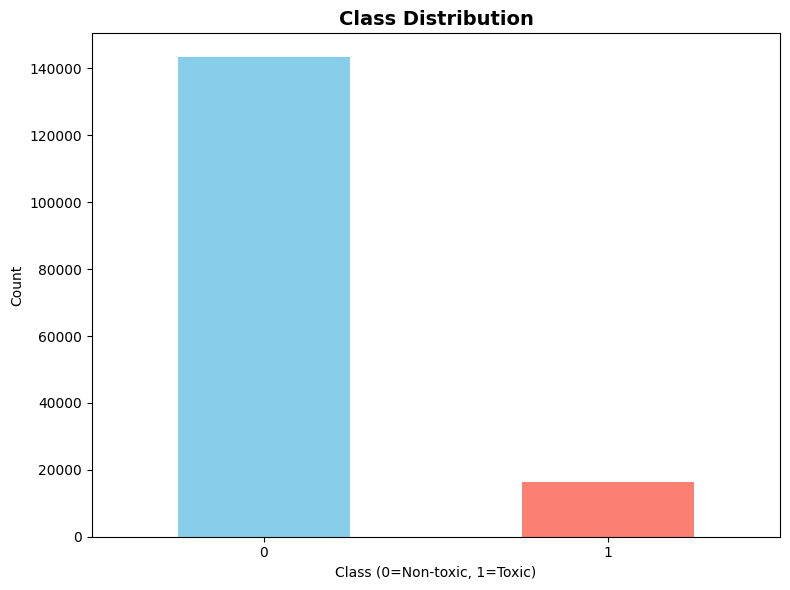

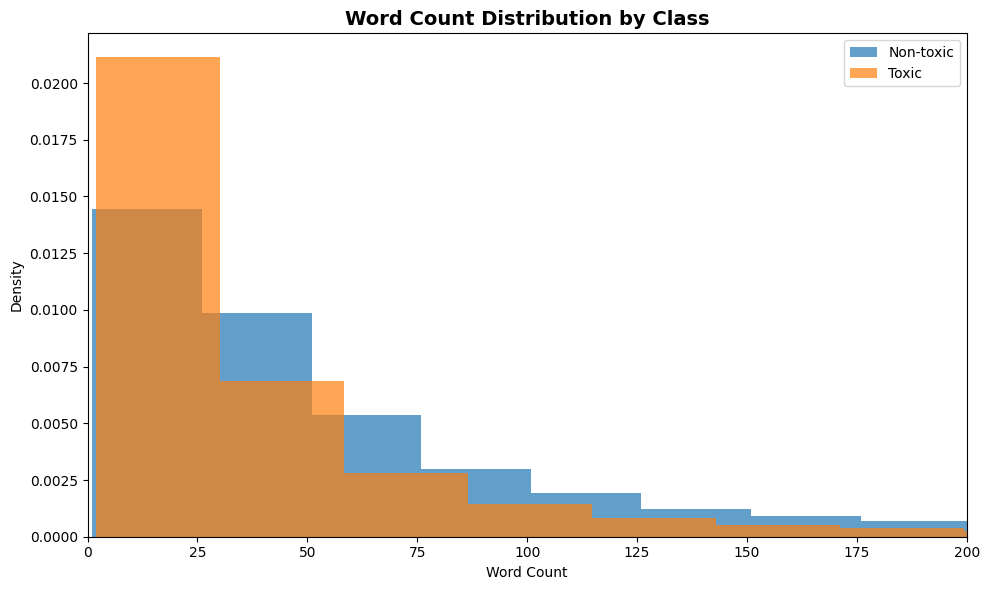

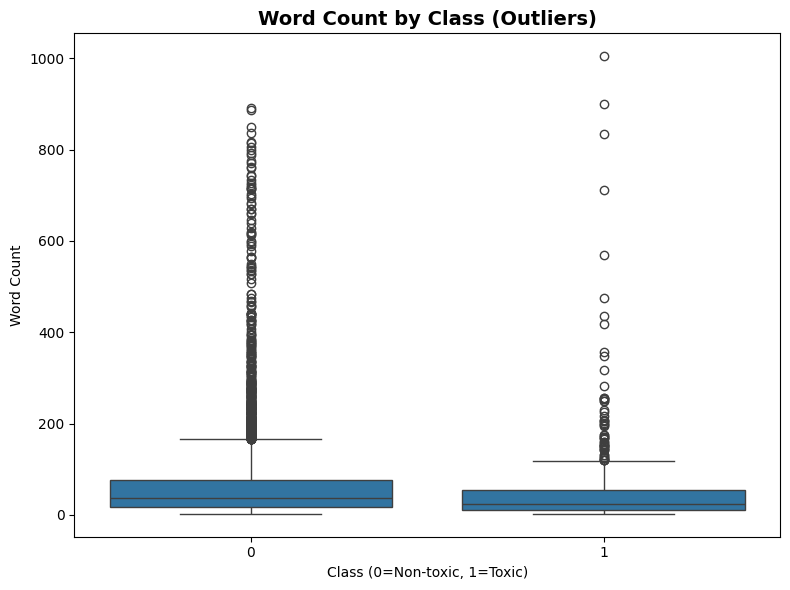

In [4]:
print("\nEXPLORATORY DATA ANALYSIS")

# Label distribution
label_dist = df['toxic'].value_counts()
print(f"Label Distribution:")
print(f"Non-toxic (0): {label_dist[0]:,} ({label_dist[0]/len(df)*100:.1f}%)")
print(f"Toxic (1): {label_dist[1]:,} ({label_dist[1]/len(df)*100:.1f}%)")
df['text_length'] = df['comment_text'].astype(str).str.len()
df['word_count'] = df['comment_text'].astype(str).str.split().str.len()
print(f"Average text length: {df['text_length'].mean():.0f} characters")
print(f"Average word count: {df['word_count'].mean():.0f} words")


# Plot 1: Label distribution
plt.figure(figsize=(8, 6))
df['toxic'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class (0=Non-toxic, 1=Toxic)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot 2: Word count distribution by class
plt.figure(figsize=(10, 6))
non_toxic_words = df[df['toxic'] == 0]['word_count']
toxic_words = df[df['toxic'] == 1]['word_count']
plt.hist(non_toxic_words, bins=50, alpha=0.7, label='Non-toxic', density=True)
plt.hist(toxic_words, bins=50, alpha=0.7, label='Toxic', density=True)
plt.title('Word Count Distribution by Class', fontsize=14, fontweight='bold')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 200)
plt.tight_layout()
plt.show()

# Plot 3: Box plot for word count comparison
plt.figure(figsize=(8, 6))
sns.boxplot(data=df.sample(5000), x='toxic', y='word_count')
plt.title('Word Count by Class (Outliers)', fontsize=14, fontweight='bold')
plt.xlabel('Class (0=Non-toxic, 1=Toxic)')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()

Rows with URLs: 5151
Rows with HTML tags: 129
Rows with quoted text: 49996
Rows with numbers: 51212


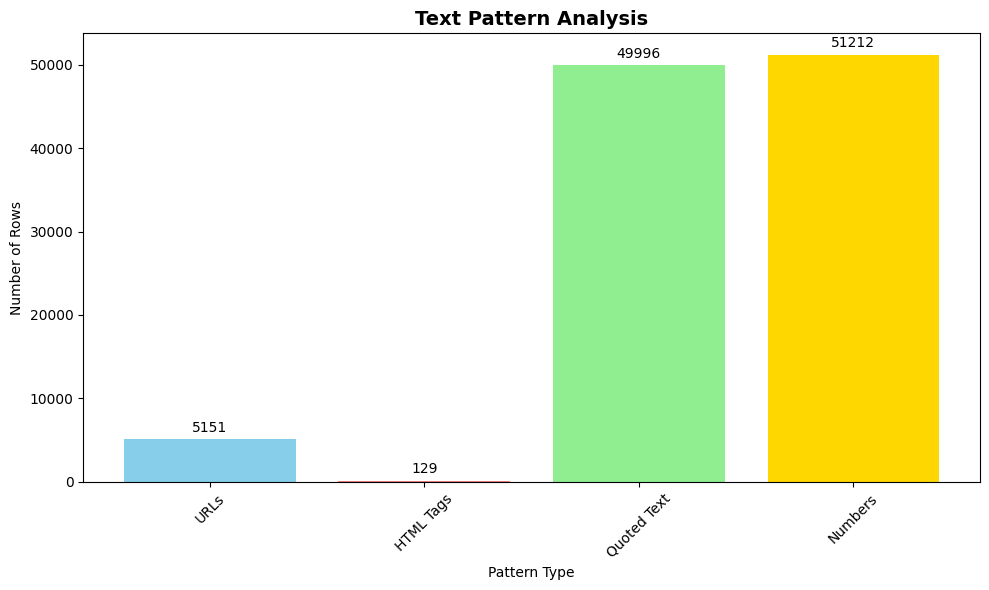

In [5]:
# Check for URLs
url_pattern = r"http\S+|www\S+"
df['has_urls'] = df['comment_text'].str.contains(url_pattern, regex=True, na=False)
print(f"Rows with URLs: {df['has_urls'].sum()}")

# Check for HTML tags
html_pattern = r"<.*?>"
df['has_html'] = df['comment_text'].str.contains(html_pattern, regex=True, na=False)
print(f"Rows with HTML tags: {df['has_html'].sum()}")

# Check for quoted text
quoted_pattern = r'"[^"]*"'
df['has_quotes'] = df['comment_text'].str.contains(quoted_pattern, regex=True, na=False)
print(f"Rows with quoted text: {df['has_quotes'].sum()}")

# Check for numbers
number_pattern = r'\d+'
df['has_numbers'] = df['comment_text'].str.contains(number_pattern, regex=True, na=False)
print(f"Rows with numbers: {df['has_numbers'].sum()}")

# Plot the pattern counts
pattern_counts = {
    'URLs': df['has_urls'].sum(),
    'HTML Tags': df['has_html'].sum(),
    'Quoted Text': df['has_quotes'].sum(),
    'Numbers': df['has_numbers'].sum()
}

plt.figure(figsize=(10, 6))
plt.bar(pattern_counts.keys(), pattern_counts.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Text Pattern Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Pattern Type')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
for i, v in enumerate(pattern_counts.values()):
    plt.text(i, v + max(pattern_counts.values()) * 0.01, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Cleaning Function

In [6]:
# expand common contractions (small set)
url = "https://raw.githubusercontent.com/andrewbury/contractions/refs/heads/master/contractions.json"
response = requests.get(url)
data = response.json()
# Convert to simple dictionary (take first option from each array)
contractions = {}
for key, value in data.items():
    contractions[key] = value[0]

def basic_clean(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', " ", text)
    # Remove quoted text
    text = re.sub(r'"[^"]*"', " ", text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    for k, v in contractions.items():
        text = text.replace(k, v)
    # remove others except english word
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [17]:
# Write lemmatization and tokenization
def tokenize_and_lemmatize(text, lemmatizer, stop_words):
    tokens = word_tokenize(text) 
    # Remove stop_word
    tokens = [t for t in tokens if t not in stop_words and t.isalpha()]
    # lemmatize
    lem = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lem)

In [18]:
# Function to load bad words from various sources
def load_bad_words():
    bad_words = set()
    # Source 1: Load Hugging Face toxic lexicon (English)
    try:
        ds = load_dataset("textdetox/multilingual_toxic_lexicon")
        en_lexicon = ds["en"]
        en_words_list = [word.strip().lower() for word in en_lexicon["text"] if word.strip()]
        bad_words.update(en_words_list)
        print(f"Loaded {len(en_words_list)} words from Hugging Face dataset")
    except Exception as e:
        print(f"Error loading Hugging Face dataset: {e}")
    # Source 2: CMU bad words list
    try:
        response = requests.get('https://www.cs.cmu.edu/~biglou/resources/bad-words.txt')
        if response.status_code == 200:
            words = response.text.strip().split('\n')
            bad_words.update([word.strip().lower() for word in words if word.strip()])
            print(f"Loaded {len(words)} words from CMU list")
    except Exception as e:
        print(f"Error loading CMU bad words: {e}")
    # Source 3: List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words
    try:
        response = requests.get('https://raw.githubusercontent.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words/refs/heads/master/en')
        if response.status_code == 200:
            words = response.text.strip().split('\n')
            github_words = [word.strip().lower() for word in words if word.strip()]
            bad_words.update(github_words)
            print(f"Loaded {len(github_words)} words from GitHub English list")
    except Exception as e:
        print(f"Error loading GitHub English bad words: {e}")
    # Source 4: Toxic Word Dictionary
    try:
        response = requests.get('https://raw.githubusercontent.com/Orthrus-Lexicon/Toxic/refs/heads/main/Toxic%20words%20dictionary.txt')
        if response.status_code == 200:
            words = response.text.strip().split('\n')
            github_words = [word.strip().lower() for word in words if word.strip()]
            bad_words.update(github_words)
            print(f"Loaded {len(github_words)} words from GitHub English list")
    except Exception as e:
        print(f"Error loading GitHub English bad words: {e}")
    # Source 5: Hinglish-Offensive-Text - github
    try:
        response = requests.get('https://raw.githubusercontent.com/pmathur5k10/Hinglish-Offensive-Text-Classification/refs/heads/main/Hinglish_Profanity_List.csv')
        if response.status_code == 200:
            csv_content = StringIO(response.text)
            csv_reader = csv.reader(csv_content)
            
            # Skip header row if present
            next(csv_reader, None)
            
            hinglish_words = []
            for row in csv_reader:
                if len(row) >= 2 and row[1].strip():  # Check if second column exists and is not empty
                    word = row[1].strip().lower()
                    if word:
                        hinglish_words.append(word)
                        bad_words.add(word)
            
            print(f"Loaded {len(hinglish_words)} words from Hinglish CSV (second column)")
    except Exception as e:
        print(f"Error loading Hinglish profanity CSV: {e}")

    # Convert set back to list and filter out any remaining empty/null values
    final_bad_words = [word for word in bad_words if word and word.strip() and len(word.strip()) > 0]
    
    # use set to remove duplicate bad_words
    return list(set(final_bad_words))


In [19]:
# Create bad words dataframe
def create_bad_words_df(bad_words_list):
    df = pd.DataFrame({'comment_text': bad_words_list})
    df['toxic'] = 1
    return df


In [20]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
print("NLTK components initialized successfully")

NLTK components initialized successfully


In [21]:
# Load bad words
bad_words_list = load_bad_words()
print(f"Total bad words loaded: {len(bad_words_list)}")

Loaded 3386 words from Hugging Face dataset
Loaded 1383 words from CMU list
Loaded 403 words from GitHub English list
Loaded 1929 words from GitHub English list
Loaded 208 words from Hinglish CSV (second column)
Total bad words loaded: 4760


In [22]:

# Create bad words dataframe
bad_words_df = create_bad_words_df(bad_words_list)
print(f"Created bad words dataset with {len(bad_words_df)} samples")

Created bad words dataset with 4760 samples


## create Training and Test Dataset  and  Model Processing and Comperasion

In [23]:
# Split original data into train (80%) and test (20%)
X = df['comment_text']
y = df['toxic']
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y
)

print(f"Original training set: {len(X_train_orig)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Bad words dataset: {len(bad_words_df)} samples")

Original training set: 127656 samples
Test set: 31915 samples
Bad words dataset: 4760 samples


In [24]:

# Create combined training set by concatenating original train data with bad words
X_train_combined = pd.concat([
    pd.DataFrame({'comment_text': X_train_orig, 'toxic': y_train_orig}),
    bad_words_df
], ignore_index=True)
print(f"combined training set: {len(X_train_combined)} samples")

combined training set: 132416 samples


In [25]:

# Text preprocessing pipeline
def preprocess_text_pipeline(texts):
    processed_texts = []
    for text in texts:
        # Basic cleaning
        cleaned = basic_clean(text)
        # Tokenize and lemmatize
        processed = tokenize_and_lemmatize(cleaned, lemmatizer, stop_words)
        processed_texts.append(processed)
    return processed_texts

In [26]:
# Preprocess all datasets
print("Preprocessing Original texts...")
X_train_orig_processed = preprocess_text_pipeline(X_train_orig)
print("Preprocessing combined texts...")
X_train_combined_processed = preprocess_text_pipeline(X_train_combined['comment_text'])
X_test_processed = preprocess_text_pipeline(X_test)

Preprocessing Original texts...
Preprocessing combined texts...


In [27]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    print(f"\n=== Evaluating {model_name} ===")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        }
    }

In [28]:
# Model 1: MultinomialNB with TFIDFVectorizer training and evaluation function
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name):
    
    # Create pipeline with TF-IDF and Multinominal Naive Bayes
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
        ('nb', MultinomialNB())
    ])
    # Train the model
    pipeline.fit(X_train, y_train)
    evaluation_results = evaluate_model(pipeline, X_test, y_test, model_name)
    return evaluation_results


In [29]:

# Model 2: MultinomialNB with CountVectorizer (bag of words) + lexicon bad_words List
# Step 1: Build vocabulary from training dataset (top 10000 features)
def build_top_vocab(texts, max_features=10000):
    """
    Extract top max_features words from training data.
    """
    # Use a temporary vectorizer to get vocabulary
    temp_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1,2))
    temp_vectorizer.fit(texts)
    vocab = set(temp_vectorizer.get_feature_names_out())
    return vocab

# Step 2: Merge with bad words list
def build_combined_vocab(train_texts, bad_words_list, max_features=10000):
    top_vocab = build_top_vocab(train_texts, max_features=max_features)
    bad_vocab = preprocess_text_pipeline(bad_words_list)
    combined_vocab = top_vocab.union(bad_vocab)   # ensure bad words included
    print(f"Top vocab size: {len(top_vocab)}")
    print(f"Bad words size: {len(bad_vocab)}")
    print(f"Final combined vocab size: {len(combined_vocab)}")
    return list(combined_vocab)

# Step 3: Train and evaluate with combined vocab
def train_with_custom_vocab(X_train, y_train, X_test, y_test, bad_words_list, model_name):
    print(f"\n=== Training {model_name} ===")

    # Build combined vocabulary
    combined_vocab = build_combined_vocab(X_train, bad_words_list, max_features=10000)


    pipeline = Pipeline([
        ('countvec', CountVectorizer(vocabulary=combined_vocab, ngram_range=(1, 2))),
        ('nb', MultinomialNB())
    ])

    # Train
    pipeline.fit(X_train, y_train)

    evaluation_results = evaluate_model(pipeline, X_test, y_test, model_name)
    return evaluation_results


In [30]:

# Model 3 : Logistic Regression with TfidfVectorizer
def train_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test, model_name="Logistic Regression"):
    
    # Create pipeline with TF-IDF and Logistic Regression
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
        ('lr', LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'))
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    evaluation_results = evaluate_model(pipeline, X_test, y_test, model_name)
    return evaluation_results


In [31]:


# Model 4 : Logistic Regression with CountVectorizer ( Bag of Words ), bad words lexicon
def train_and_evaluate_logistic_regression_cv(X_train, y_train, X_test, y_test, model_name="Logistic Regression"):
    print(f"\n=== Training {model_name} ===")

    combined_vocab = build_combined_vocab(X_train, bad_words_list, max_features=10000)
    
    # Create pipeline with TF-IDF and Logistic Regression
    pipeline = Pipeline([
        ('countvec', CountVectorizer(vocabulary=combined_vocab, ngram_range=(1, 2))),
        ('lr', LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'))
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    evaluation_results = evaluate_model(pipeline, X_test, y_test, model_name)
    return evaluation_results


In [32]:

# Model 1
model_1_results = train_and_evaluate_model(
    X_train_orig_processed, y_train_orig, X_test_processed, y_test,
    "Multinomial Naive Bayes ( TFIDF )"
)


=== Evaluating Multinomial Naive Bayes ( TFIDF ) ===
Accuracy: 0.9432
F1-Score: 0.6287
Precision: 0.9382
Recall: 0.4727
True Positives: 1534
True Negatives: 28569
False Positives: 101
False Negatives: 1711

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28670
           1       0.94      0.47      0.63      3245

    accuracy                           0.94     31915
   macro avg       0.94      0.73      0.80     31915
weighted avg       0.94      0.94      0.93     31915



In [33]:
# Model 2 
model_2_results = train_with_custom_vocab(
    X_train_combined_processed, X_train_combined['toxic'], 
    X_test_processed, y_test, bad_words_list,
    "Multinomial Naive Bayes (Feature + lexicon + Bag of wrods)"
)


=== Training Multinomial Naive Bayes (Feature + lexicon + Bag of wrods) ===
Top vocab size: 10000
Bad words size: 4760
Final combined vocab size: 13836

=== Evaluating Multinomial Naive Bayes (Feature + lexicon + Bag of wrods) ===
Accuracy: 0.9460
F1-Score: 0.6717
Precision: 0.8797
Recall: 0.5433
True Positives: 1763
True Negatives: 28429
False Positives: 241
False Negatives: 1482

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28670
           1       0.88      0.54      0.67      3245

    accuracy                           0.95     31915
   macro avg       0.92      0.77      0.82     31915
weighted avg       0.94      0.95      0.94     31915



In [34]:
#Model 3 
model_3_results = train_and_evaluate_logistic_regression(
    X_train_orig_processed,
    y_train_orig,
    X_test_processed,
    y_test,
    model_name="Logistic Regression (TFIDF)"
)



=== Evaluating Logistic Regression (TFIDF) ===
Accuracy: 0.9322
F1-Score: 0.6925
Precision: 0.6425
Recall: 0.7510
True Positives: 2437
True Negatives: 27314
False Positives: 1356
False Negatives: 808

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     28670
           1       0.64      0.75      0.69      3245

    accuracy                           0.93     31915
   macro avg       0.81      0.85      0.83     31915
weighted avg       0.94      0.93      0.93     31915



In [35]:
model_4_results = train_and_evaluate_logistic_regression_cv(
    X_train_combined_processed,   
    X_train_combined['toxic'],
    X_test_processed,
    y_test,
    model_name="Logistic Regression (Feature + lexicon + Bag of wrods)"
)


=== Training Logistic Regression (Feature + lexicon + Bag of wrods) ===
Top vocab size: 10000
Bad words size: 4760
Final combined vocab size: 13836

=== Evaluating Logistic Regression (Feature + lexicon + Bag of wrods) ===
Accuracy: 0.9375
F1-Score: 0.7062
Precision: 0.6766
Recall: 0.7384
True Positives: 2396
True Negatives: 27525
False Positives: 1145
False Negatives: 849

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     28670
           1       0.68      0.74      0.71      3245

    accuracy                           0.94     31915
   macro avg       0.82      0.85      0.84     31915
weighted avg       0.94      0.94      0.94     31915



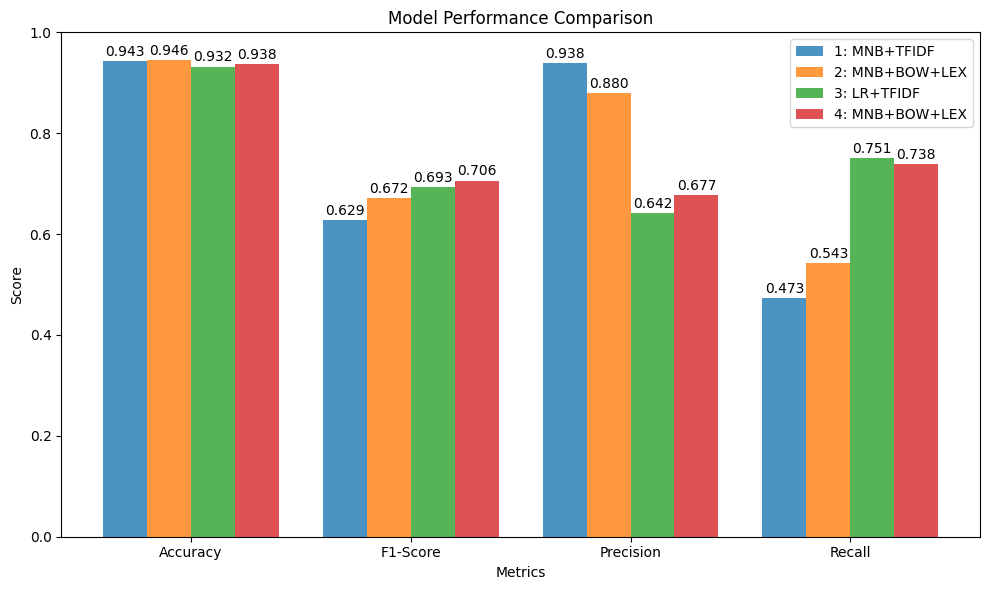

In [36]:
# Metrics comparison
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

model1_scores = [
    model_1_results['metrics']['accuracy'],
    model_1_results['metrics']['f1_score'],
    model_1_results['metrics']['precision'],
    model_1_results['metrics']['recall']
]
model2_scores = [
    model_2_results['metrics']['accuracy'],
    model_2_results['metrics']['f1_score'],
    model_2_results['metrics']['precision'],
    model_2_results['metrics']['recall']
]
model3_scores = [
    model_3_results['metrics']['accuracy'],
    model_3_results['metrics']['f1_score'],
    model_3_results['metrics']['precision'],
    model_3_results['metrics']['recall']
]
model4_scores = [
    model_4_results['metrics']['accuracy'],
    model_4_results['metrics']['f1_score'],
    model_4_results['metrics']['precision'],
    model_4_results['metrics']['recall']
]

x = np.arange(len(metrics))
width = 0.2  # shrink width since we have 4 bars

plt.bar(x - 1.5*width, model1_scores, width, label='1: MNB+TFIDF', alpha=0.8)
plt.bar(x - 0.5*width, model2_scores, width, label='2: MNB+BOW+LEX', alpha=0.8)
plt.bar(x + 0.5*width, model3_scores, width, label='3: LR+TFIDF', alpha=0.8)
plt.bar(x + 1.5*width, model4_scores, width, label='4: MNB+BOW+LEX', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Adding text labels on top of bars
for i in range(len(metrics)):
    plt.text(x[i] - 1.5*width, model1_scores[i] + 0.01, f'{model1_scores[i]:.3f}', ha='center')
    plt.text(x[i] - 0.5*width, model2_scores[i] + 0.01, f'{model2_scores[i]:.3f}', ha='center')
    plt.text(x[i] + 0.5*width, model3_scores[i] + 0.01, f'{model3_scores[i]:.3f}', ha='center')
    plt.text(x[i] + 1.5*width, model4_scores[i] + 0.01, f'{model4_scores[i]:.3f}', ha='center')

plt.tight_layout()
plt.show()


In [37]:
# Summary comparison
print("\n" + "="*60)
print("FINAL COMPARISON SUMMARY")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['1: MNB+TFIDF', '2: MNB+BOW+LEX', '3: LR+TFIDF', '4: MNB+BOW+LEX'],
    'Accuracy': [
        model_1_results['metrics']['accuracy'],
        model_2_results['metrics']['accuracy'],
        model_3_results['metrics']['accuracy'],
        model_4_results['metrics']['accuracy']
    ],
    'F1-Score': [
        model_1_results['metrics']['f1_score'],
        model_2_results['metrics']['f1_score'],
        model_3_results['metrics']['f1_score'],
        model_4_results['metrics']['f1_score']
    ],
    'Precision': [
        model_1_results['metrics']['precision'],
        model_2_results['metrics']['precision'],
        model_3_results['metrics']['precision'],
        model_4_results['metrics']['precision']
    ],
    'Recall': [
        model_1_results['metrics']['recall'],
        model_2_results['metrics']['recall'],
        model_3_results['metrics']['recall'],
        model_4_results['metrics']['recall']
    ],
    'True Positives': [
        model_1_results['metrics']['tp'],
        model_2_results['metrics']['tp'],
        model_3_results['metrics']['tp'],
        model_4_results['metrics']['tp']
    ],
    'True Negatives': [
        model_1_results['metrics']['tn'],
        model_2_results['metrics']['tn'],
        model_3_results['metrics']['tn'],
        model_4_results['metrics']['tn']
    ],
    'False Positives': [
        model_1_results['metrics']['fp'],
        model_2_results['metrics']['fp'],
        model_3_results['metrics']['fp'],
        model_4_results['metrics']['fp']
    ],
    'False Negatives': [
        model_1_results['metrics']['fn'],
        model_2_results['metrics']['fn'],
        model_3_results['metrics']['fn'],
        model_4_results['metrics']['fn']
    ]
})



FINAL COMPARISON SUMMARY


C:\Users\mala\AppData\Local\Temp\ipykernel_18076\399570273.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # You can try other colormaps like 'coolwarm', 'viridis'


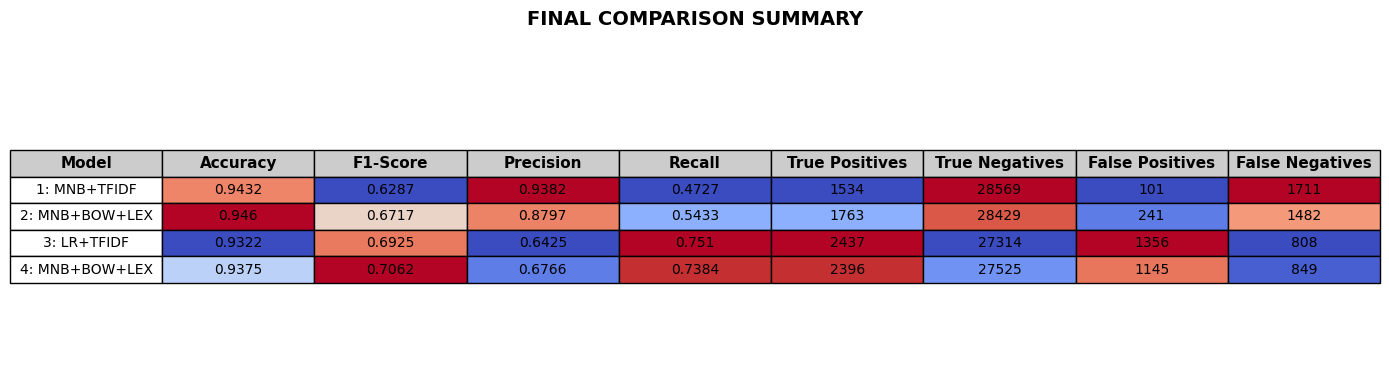

In [38]:

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 4))
ax.axis('tight')
ax.axis('off')

display_df = comparison_df.copy()
display_df[['Accuracy', 'F1-Score', 'Precision', 'Recall']] = display_df[['Accuracy', 'F1-Score', 'Precision', 'Recall']].round(4)

# Create the table
table = ax.table(cellText=display_df.values,
                 colLabels=display_df.columns,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Apply color to cells based on value (heatmap style)
# Exclude 'Model' column
cmap = cm.get_cmap('coolwarm')  # You can try other colormaps like 'coolwarm', 'viridis'

for col_idx in range(1, len(display_df.columns)):  # skip 'Model' (index 0)
    col_values = display_df.iloc[:, col_idx].astype(float)
    norm = mcolors.Normalize(vmin=col_values.min(), vmax=col_values.max())

    for row_idx in range(len(display_df)):
        value = col_values.iloc[row_idx]
        color = cmap(norm(value))
        cell = table[row_idx + 1, col_idx]  # +1 for header row
        cell.set_facecolor(color)

# Bold the header
for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(11)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#cccccc')

plt.title("FINAL COMPARISON SUMMARY", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [39]:


# Determine which model is better (based on F1-score)
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1-Score']

print(f"\nCONCLUSION: The best performing model is **{best_model_name}**")
print(f"Highest F1-Score: {best_f1:.4f}")



CONCLUSION: The best performing model is **4: MNB+BOW+LEX**
Highest F1-Score: 0.7062


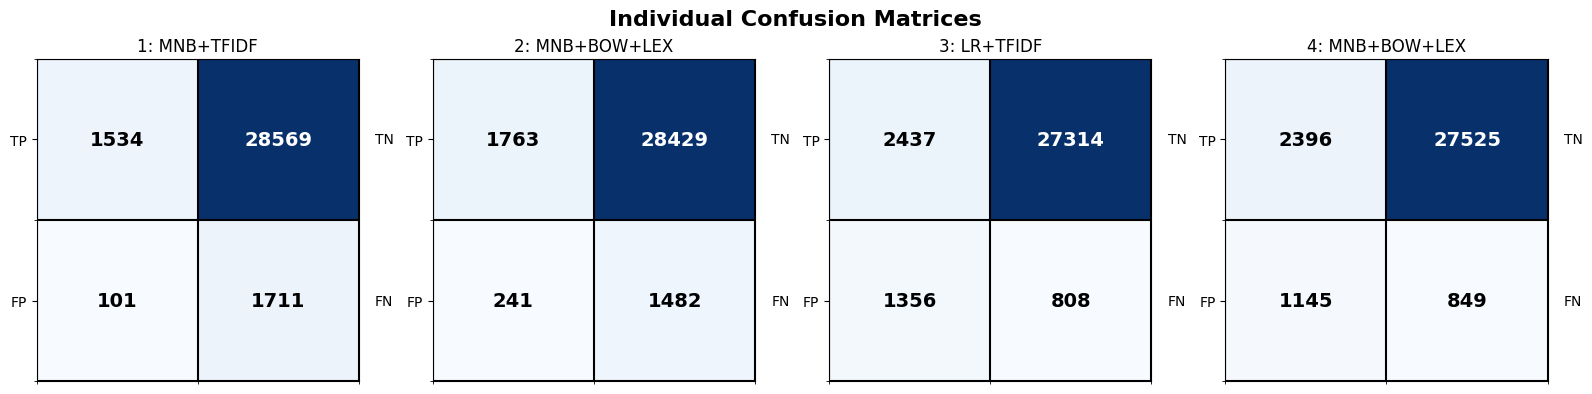

In [40]:

# Extract confusion matrix data
models = comparison_df['Model'].values
tp = comparison_df['True Positives'].values
tn = comparison_df['True Negatives'].values
fp = comparison_df['False Positives'].values
fn = comparison_df['False Negatives'].values

# Individual confusion matrices as heatmaps
fig, axes = plt.subplots(1, len(models), figsize=(4*len(models), 4))
fig.suptitle('Individual Confusion Matrices', fontsize=16, fontweight='bold')

for i, model in enumerate(models):
    conf_matrix = np.array([[tp[i], tn[i]], 
                            [fp[i], fn[i]]])
    
    ax = axes[i] if len(models) > 1 else axes
    im = ax.imshow(conf_matrix, cmap='Blues', aspect='equal')
    
    # Add title
    ax.set_title(f'{model}')
    right_labels = ['TN', 'FN']
    for j, label in enumerate(right_labels):
        ax.text(1.6, j, label, va='center', fontsize=10, color='black')
    
    # Set tick labels
    ax.set_xticks([])
    ax.set_yticks([0,1])
    ax.set_yticklabels(['TP', 'FP'])
    
    # Add grid lines
    ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1.5)
    
    # Annotate values
    for row in range(2):
        for col in range(2):
            value = conf_matrix[row, col]
            ax.text(col, row, f'{value:.0f}',
                    ha="center", va="center",
                    color="white" if value > conf_matrix.max()/2 else "black",
                    fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
